In [6]:
import pymc3 as pm
import pandas as pd
import matplotlib 

from sklearn.preprocessing import LabelEncoder


%matplotlib inline

## Problem Type

The Bayesian estimation model is widely applicable across a number of scenarios. The classical scenario is when we have an experimental design where there is a control vs. a treatment, and we want to know what the difference is between the two. Here, "estimation" is used to estimate the "true" value for the control and the "true" value for the treatment, and the "Bayesian" part refers to the computation of the uncertainty surrounding the parameter. 

Bayesian estimation's advantages over the classical t-test was first described by John Kruschke (2013). 

In this notebook, I provide a concise implementation suitable for two-sample and multi-sample inference.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement.
- The columns should indicate, at the minimum:
    - What treatment group the sample belonged to.
    - The measured value.

## Extensions to the model

As of now, the model only samples posterior distributions of measured values. The model, then, may be extended to compute differences in means (sample vs. control) or effect sizes, complete with uncertainty around it. Use `pm.Deterministic(...)` to ensure that those statistics' posterior distributions, i.e. uncertainty, are also computed.

## Reporting summarized findings

Here are examples of how to summarize the findings.

> Treatment group A was greater than control by x units (95% HPD: [`lower`, `upper`]). 

> Treatment group A was higher than control (effect size 95% HPD: [`lower`, `upper`]). 

## Other notes

Here, we make a few modelling choices.

1. We care only about the `normalized_measurement` column, and so we choose the t-distribution to model it, as we don't have a good "mechanistic" model that incorporates measurement error of OD600 and 'measurement'.

In [7]:
df = pd.read_csv('datasets/biofilm.csv')
df.head()

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement
0,1,1,4,0.461,0.317,1,0.687636
1,1,2,55,0.346,0.434,1,1.254335
2,1,3,55,0.356,0.917,1,2.575843
3,1,4,4,0.603,1.061,1,1.759536
4,1,5,330,0.444,3.701,1,8.335586


In [8]:

le = LabelEncoder()
le.fit(df['isolate'])
df['indices'] = le.transform(df['isolate'])

In [9]:
le.classes_

array(['1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6',
       '7', '8', '9', 'ATCC_29212'], dtype=object)

In [10]:
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_one', lam=1/30) + 1
    
    fold = pm.Flat('fold', shape=len(le.classes_))
    
    var = pm.HalfCauchy('var', beta=1, shape=len(le.classes_))
    
    mu = fold[df['indices']]
    sd = var[df['indices']]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, observed=df['normalized_measurement'])
    
    # Compute differences
    diffs = pm.Deterministic('differences', fold - fold[0])

In [11]:
with best:
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -59.088: 100%|██████████| 200000/200000 [00:19<00:00, 10035.17it/s]
Finished [100%]: Average ELBO = -59.144
100%|██████████| 2000/2000 [00:09<00:00, 221.48it/s]


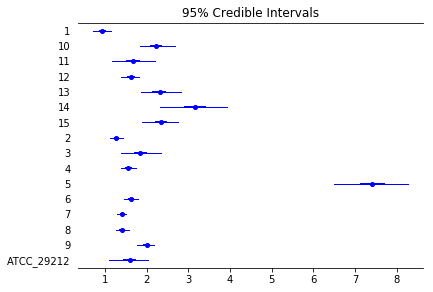

In [12]:
pm.forestplot(trace, varnames=['fold'], ylabels=le.classes_)

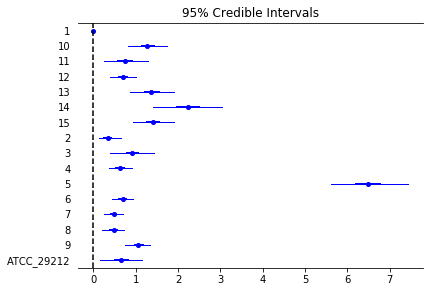

In [13]:
pm.forestplot(trace, varnames=['differences'], ylabels=le.classes_)